In [ ]:
"""
QCB 551: Final Project - Figure 1C Reproduction
Author: Annita Chang (wc7800)
This notebook reproduces Fig 1C from the referenced dataset GSE211644,
showing transcription factor expression in CD4+ and CD8+ T cell subsets.
"""

import pandas as pd
from scipy import io
import scanpy as sc

# Download Supplementary Files listed on https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE211644 before running this
base = "../GSE211644"

# read matrix and metadata
mat = io.mmread(f"{base}/GSE211644_fresh_matrix.mtx.gz").T.tocsr() # transpose and make sparse for efficient storage
genes = pd.read_csv(f"{base}/GSE211644_fresh_genes.tsv.gz", sep="\t", header=None)
barcodes = pd.read_csv(f"{base}/GSE211644_fresh_barcodes.tsv.gz", sep="\t", header=None)
meta = pd.read_csv(f"{base}/GSE211644_fresh_metadata.csv")
meta["sample"] = meta["barcode"].str.split("_").str[0]

# make AnnData object
adata = sc.AnnData(X=mat) # cell x gene matrix
adata.obs_names = barcodes.iloc[:, 0].astype(str).values # cells
adata.var_names = genes.iloc[:, 0].astype(str).values # genes
meta.index = meta["barcode"]
adata.obs = meta.reindex(adata.obs_names)
# adata = adata[adata.obs["sample"] == "MDA1"].copy()


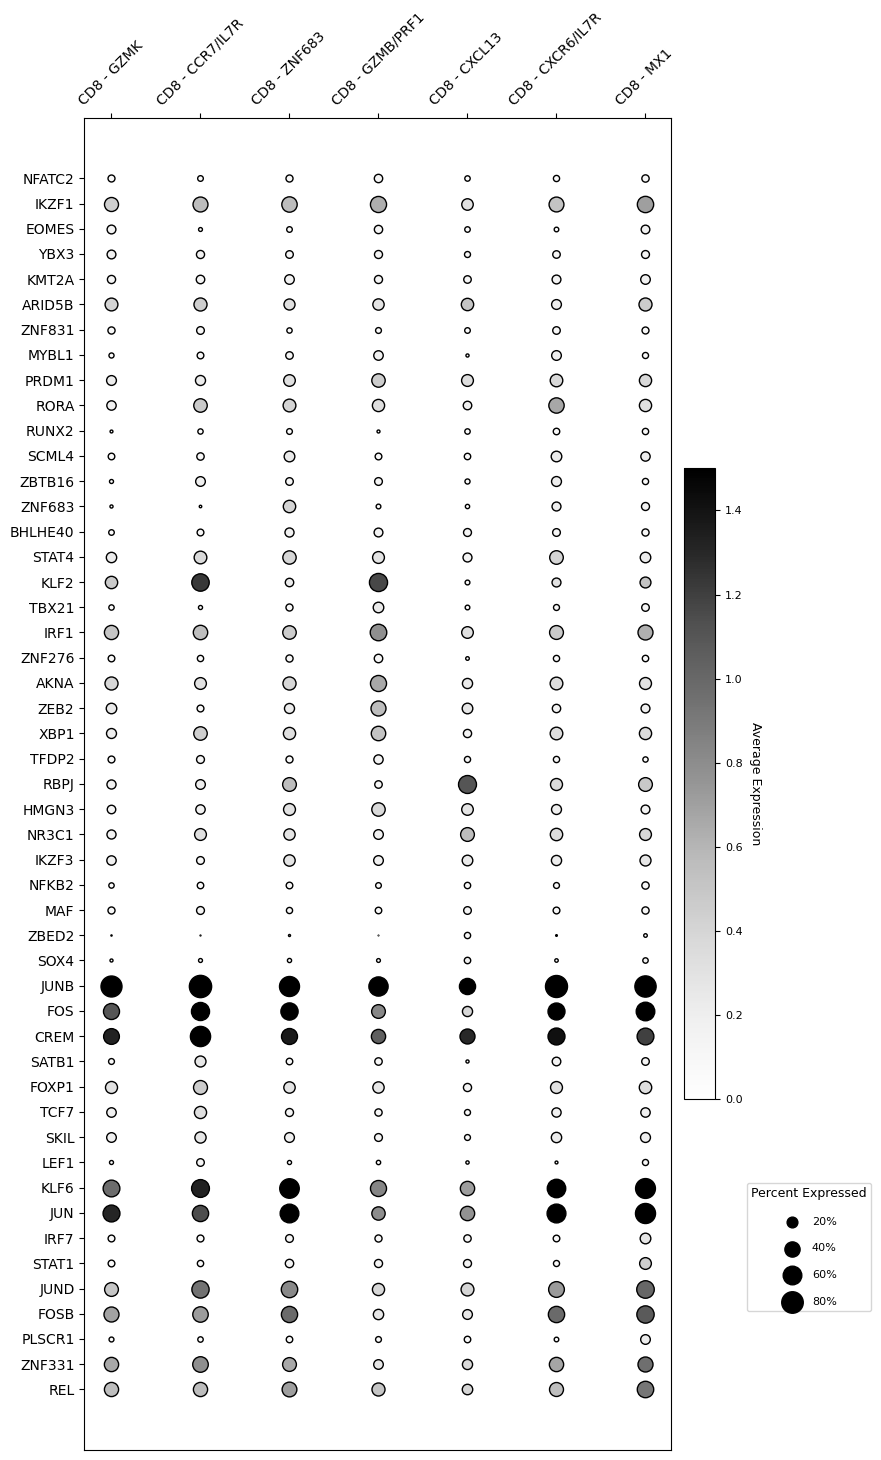

Gene BATE not found


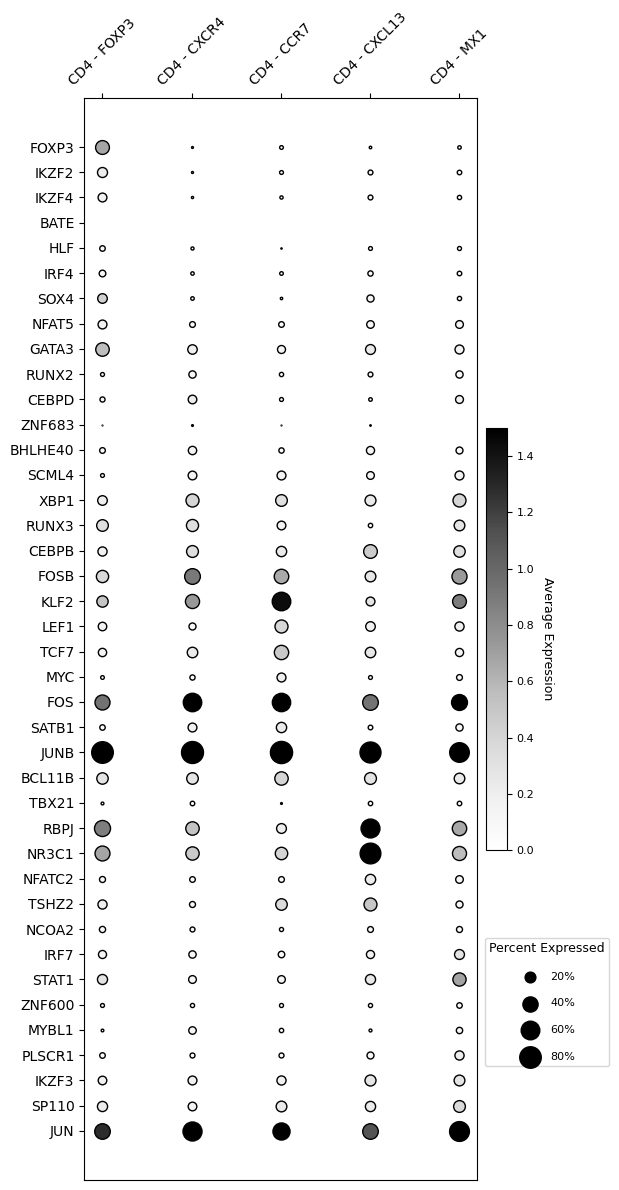

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple

# Read in TF gene lists
cd4_tfs = pd.read_csv("../1c_cd4_tf.txt", header=None)[0].str.strip().values.tolist()[::-1]
cd8_tfs = pd.read_csv("../1c_cd8_tf.txt", header=None)[0].str.strip().values.tolist()[::-1]

# Get all clusters for CD4+ and CD8+
cd4_clusters = ['CD4 - FOXP3', 'CD4 - CXCR4', 'CD4 - CCR7', 'CD4 - CXCL13',  'CD4 - MX1']
cd8_clusters = ['CD8 - GZMK', 'CD8 - CCR7/IL7R', 'CD8 - ZNF683', 'CD8 - GZMB/PRF1', 'CD8 - CXCL13', 'CD8 - CXCR6/IL7R', 'CD8 - MX1']

def make_dotplot(adata, clusters, tf_list):
    """
    Create a dot plot visualizing average expression and 
    fraction of expressing cells for given transcription factors (TFs) 
    across specified cell clusters.

    adata: AnnData object containing gene expression data (cells x genes) and cell metadata.
    clusters: Names of cd4/cd8 clusters.
    tf_list: List of transcription factors.
    """
    cluster_cells = [adata.obs['cluster'] == clus for clus in clusters]
    data = []
    fractions = []
    for gene in tf_list:
        # get tf expression for all cells
        if gene in adata.var_names:
            gene_row = adata[:, gene].X.toarray()#.flatten()
        else:
            print(f"Gene {gene} not found")
            gene_row = np.full(adata.shape[0], np.nan)
        gene_expr_levels = []
        gene_fractions = []
        for mask in cluster_cells:
            expr = gene_row[mask]
            # get the number of cells that express the tf
            is_expr = expr > 0
            # get the mean expression level of the tf
            mean_expr = expr.mean() if np.any(is_expr) else 0
            # get the fraction of cells that express the tf
            frac_expr = is_expr.sum() / mask.sum()
            gene_expr_levels.append(mean_expr)
            gene_fractions.append(frac_expr)
        data.append(gene_expr_levels)
        fractions.append(gene_fractions)
    data = np.array(data)
    fractions = np.array(fractions)
    
    # Create dot plot
    plt.figure(figsize=(len(clusters)*1.3, len(tf_list)*0.3))
    for i in range(len(tf_list)):
        for j in range(len(clusters)):
            plt.scatter(j, i, s=fractions[i, j]*300, c=np.array([[data[i, j]]]), 
                        cmap='Greys', vmin=0, vmax=1.5, edgecolors='k')

    # Add colorbar legend for expression level
    sm = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0, vmax=1.5))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label('Average Expression', rotation=270, labelpad=14, fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    # Add dot size legend for percent expressed
    legend_sizes = [0.2, 0.4, 0.6, 0.8]
    for idx, frac in enumerate(legend_sizes):
        plt.scatter([], [], s=frac*300, c='black', edgecolors='k', label=f'{int(frac*100)}%')
    plt.legend(
        title='Percent Expressed',
        loc='lower right', 
        bbox_to_anchor=(1.35, 0.1),
        scatterpoints=1,
        frameon=True,
        fontsize=8,
        title_fontsize=9,
        labelspacing=1.5,
        ncol=1)
    
    # adjust ticks and labels
    plt.xticks(np.arange(len(clusters)), clusters, rotation=45)
    plt.gca().xaxis.set_label_position('top')
    plt.gca().xaxis.tick_top()
    plt.yticks(np.arange(len(tf_list)), tf_list)
    plt.tight_layout()
    plt.show()
    return tf_list, data, fractions
    
tf8, d8, f8 = make_dotplot(adata, cd8_clusters, cd8_tfs)
tf4, d4, f4 = make_dotplot(adata, cd4_clusters, cd4_tfs)



